In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [10]:
data_df.isna().sum().sum()

76984

In [11]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [12]:
data_df[data_df['Name']=="S. Chhetri"]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
8605,8605,190939,S. Chhetri,33,https://cdn.sofifa.org/players/4/19/190939.png,India,https://cdn.sofifa.org/flags/159.png,67,67,NaN,...,67.0,30.0,24.0,44.0,10.0,7.0,11.0,9.0,10.0,NaN


In [13]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [14]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [15]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [16]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [17]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [18]:
features_df = data_df.drop('Position', axis=1)
labels_df = data_df['Position']

In [19]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df,
                                     labels_df,
                                     stratify=labels_df,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [20]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [21]:
# important to reset the indies as we will be fetching by index

# train_df = train_df.reset_index(drop=True)
display (X_train.shape)

# test_df = test_df.reset_index(drop=True)
display(X_test.shape)

(14517, 33)

(3630, 33)

In [22]:
list(labels.keys())

[0, 1, 2, 3]

In [23]:
import tensorflow as tf

In [24]:
# Calling class Sequential and pass all layers as a list
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(18, activation=tf.nn.silu), # alternatively activation = 'swish' 
  tf.keras.layers.Dense(4) # notice absence of softmax function
])

In [25]:
tf.__version__

'2.15.1'

In [26]:
inputs = tf.keras.Input(shape = (33,))

x = tf.keras.layers.Dense(18, activation= tf.nn.relu)(inputs)

outputs = tf.keras.layers.Dense(4)(x)

model1 = tf.keras.Model(inputs = inputs, outputs = outputs)

In [27]:
predictions = model(X_train[:1]).numpy()
predictions

array([[-0.81965613, -0.10281361,  0.75643873,  0.22611724]],
      dtype=float32)

In [28]:
predictions.sum()

0.060086235

In [29]:
predictions1 = model1(X_train[:1]).numpy()
predictions1

array([[-0.5422237,  1.2238891,  0.5397292, -0.665383 ]], dtype=float32)

In [30]:
predictions1.sum()

0.55601156

In [31]:
tf.nn.softmax(predictions).numpy()

array([[0.09320022, 0.19087002, 0.45071945, 0.26521042]], dtype=float32)

In [32]:
tf.nn.softmax(predictions).numpy().sum()

1.0000001

In [33]:
tf.nn.softmax(predictions1).numpy()

array([[0.09360987, 0.5474376 , 0.27618986, 0.08276261]], dtype=float32)

In [34]:
tf.nn.softmax(predictions1).numpy().sum()

0.99999994

Layer 1 -> 33*18 + 18 = 612 \
           inputs * outputs + outputs

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 18)                612       
                                                                 
 dense_3 (Dense)             (None, 4)                 76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
print('Max Float: ',sys.float_info.max, '\nMin Float: ',sys.float_info.min)

Max Float:  1.7976931348623157e+308 
Min Float:  2.2250738585072014e-308


In [38]:
np.log(sys.float_info.max)
# We can get exp max till 709.782712893384, if we try to find exp of value greater than it, pc will return infinity

709.782712893384

In [39]:
np.exp(709.79)

C:\Users\Administrator.DAI-PC2\AppData\Local\Temp\ipykernel_21312\2417250246.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(709.79)


inf

In [40]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [41]:
loss_fn

In [42]:
y_train[:1]

14537    3
Name: Position, dtype: int8

In [43]:
loss_fn(y_train[:1], predictions).numpy()

1.3272319

In [44]:
loss_fn(y_train[:1], predictions1).numpy()

2.4917789

In [45]:
model.compile(optimizer='adam',
              loss = loss_fn,
              metrics = ['accuracy'])

In [46]:
history = model.fit(X_train, y_train, 
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS)

Epoch 1/101




454/454 [==============================] - 3s 4ms/step - loss: 0.5909 - accuracy: 0.7701 - val_loss: 0.3819 - val_accuracy: 0.8391
Epoch 2/101
454/454 [==============================] - 2s 3ms/step - loss: 0.3462 - accuracy: 0.8572 - val_loss: 0.3387 - val_accuracy: 0.8559
Epoch 3/101
454/454 [==============================] - 2s 3ms/step - loss: 0.3211 - accuracy: 0.8666 - val_loss: 0.3249 - val_accuracy: 0.8579
Epoch 4/101
454/454 [==============================] - 2s 3ms/step - loss: 0.3093 - accuracy: 0.8716 - val_loss: 0.3166 - val_accuracy: 0.8639
Epoch 5/101
454/454 [==============================] - 2s 4ms/step - loss: 0.3022 - accuracy: 0.8756 - val_loss: 0.3112 - val_accuracy: 0.8697
Epoch 6/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2970 - accuracy: 0.8771 - val_loss: 0.3065 - val_accuracy: 0.8702
Epoch 7/101
454/454 [==============================] - 2s 3ms/step - loss: 0.2937 - accuracy: 0.8780 - val_loss: 0.3056 - val_accuracy: 0.8675
Epoch 8/10

In [47]:
model.evaluate(X_test, y_test, verbose=2)

114/114 - 0s - loss: 0.3047 - accuracy: 0.8733 - 264ms/epoch - 2ms/step


[0.30473047494888306, 0.8732782602310181]

In [48]:
history.params

{'verbose': 1, 'epochs': 101, 'steps': 454}

In [49]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [50]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [51]:
# pd.DataFrame(history.history).plot(figsize=(8,5))
# plt.show()

In [52]:


# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter( y=history.history['val_loss'], name="val_loss"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter( y=history.history['loss'], name="loss"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
#     secondary_y=True,
# )

# fig.add_trace(
#     go.Scatter( y=history.history['accuracy'], name="val accuracy"),
#     secondary_y=True,
# )

# # Add figure title
# fig.update_layout(
#     title_text="Loss/Accuracy of LSTM Model"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Epoch")

# # Set y-axes titles
# fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

# fig.show()

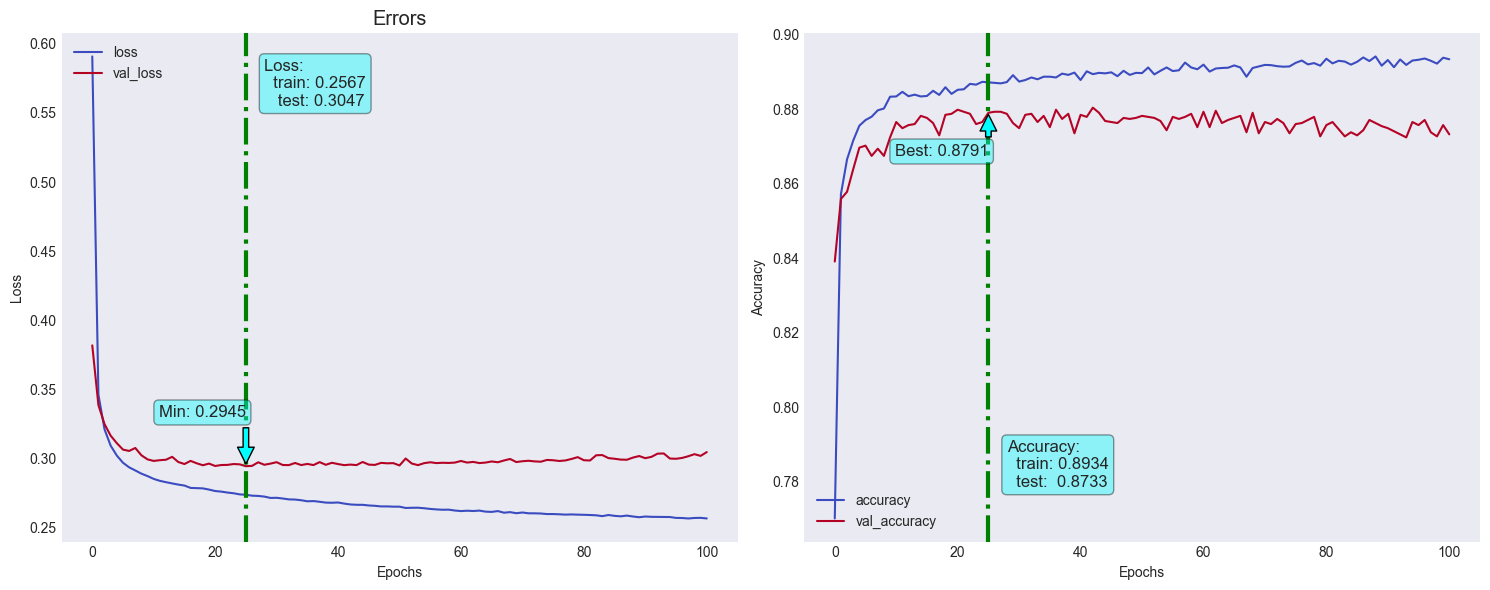

In [53]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

Epoch 1/101
454/454 [==============================] - 2s 3ms/step - loss: 0.6326 - accuracy: 0.7340 - val_loss: 0.3890 - val_accuracy: 0.8287
Epoch 2/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3484 - accuracy: 0.8564 - val_loss: 0.3352 - val_accuracy: 0.8534
Epoch 3/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3188 - accuracy: 0.8684 - val_loss: 0.3195 - val_accuracy: 0.8567
Epoch 4/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3086 - accuracy: 0.8729 - val_loss: 0.3122 - val_accuracy: 0.8642
Epoch 5/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3012 - accuracy: 0.8759 - val_loss: 0.3069 - val_accuracy: 0.8689
Epoch 6/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2962 - accuracy: 0.8791 - val_loss: 0.3047 - val_accuracy: 0.8702
Epoch 7/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2926 - accuracy: 0.8802 - val_loss: 0.3060 - val_accuracy: 0.8661

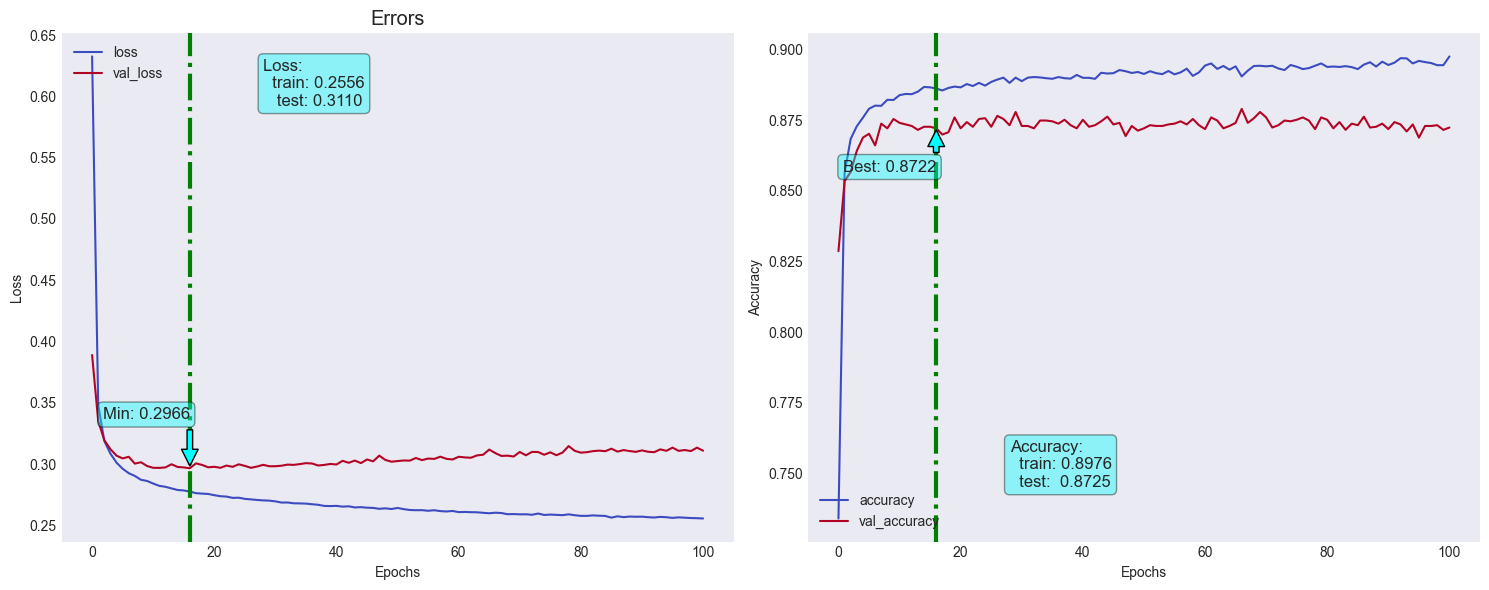

In [54]:
model1.compile(optimizer='adam',
              loss = loss_fn,
              metrics = ['accuracy'])
history = model1.fit(X_train, y_train, 
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS)
model1.evaluate(X_test, y_test, verbose=2)
loss_df1 = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df1)

In [55]:
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.590914,0.770132,0.381904,0.839118
1,0.346243,0.857202,0.338727,0.855923
2,0.321099,0.866570,0.324909,0.857851
3,0.309299,0.871599,0.316551,0.863912
4,0.302183,0.875594,0.311152,0.869697


Predictions


In [56]:
probability_model= tf.keras.Sequential([
    model, 
    tf.keras.layers.Softmax()
])

In [57]:
y_pred = probability_model(X_test).numpy()
y_pred

array([[7.2559087e-24, 1.3663471e-08, 3.2067803e-01, 6.7932194e-01],
       [1.0962016e-19, 2.0616784e-07, 8.0226600e-01, 1.9773382e-01],
       [7.5212975e-11, 3.5076751e-04, 2.9702410e-01, 7.0262510e-01],
       ...,
       [4.9512851e-06, 6.9598374e-03, 9.6467018e-01, 2.8365023e-02],
       [2.0026292e-15, 7.9826088e-05, 9.7128290e-01, 2.8637309e-02],
       [6.2173044e-23, 6.5574932e-01, 3.4424502e-01, 5.6877661e-06]],
      dtype=float32)

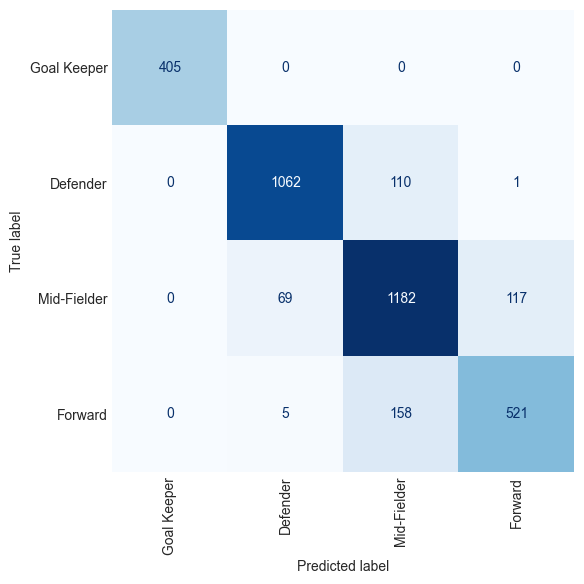

In [60]:
fn_plot_confusion_matrix(y_test, y_pred.argmax(axis=1), labels)

In [64]:
tf.keras.models.save_model(
    model, os.path.join(modelDir,subDir)
)

INFO:tensorflow:Assets written to: ./models\fifa_2019\assets


INFO:tensorflow:Assets written to: ./models\fifa_2019\assets


In [63]:
model.save("tf_model.keras")